In [1]:
# 导入相应的库
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')


# 设置格式
plt.style.use('seaborn')
plt.rcParams['figure.figsize']=[12,6]
plt.rcParams['figure.dpi']=300

In [2]:
#读取数据
temp_data = pd.read_csv('P888.csv')

In [3]:
##原数据展示
temp_data.head()

,order_book_id,datetime,trading_date,low,volume,high,close,open,total_turnover,open_interest,dominant_id
0,P888,2011-01-04 09:05:00,2011-01-04,7416.0,12970.0,7454.0,7450.0,7438.0,1.273598e+09,154272.0,P1109
1,P888,2011-01-04 09:10:00,2011-01-04,7448.0,9104.0,7482.0,7468.0,7450.0,8.966740e+08,155654.0,P1109
2,P888,2011-01-04 09:15:00,2011-01-04,7452.0,5756.0,7476.0,7454.0,7468.0,5.667175e+08,156628.0,P1109
3,P888,2011-01-04 09:20:00,2011-01-04,7434.0,5588.0,7456.0,7434.0,7452.0,5.492775e+08,157212.0,P1109
4,P888,2011-01-04 09:25:00,2011-01-04,7434.0,3484.0,7448.0,7448.0,7434.0,3.423084e+08,156784.0,P1109


In [4]:
#1.按照天为单位，对数据进行合并
#2.只保留date close open volume turnover
daily_open = []
daily_close = []
daily_volume = []
daily_turnover = []
total_days = list(temp_data['trading_date'])
total_days = sorted(set(total_days),key=total_days.index)
for day in total_days:
    temp_data_temp = temp_data[temp_data['trading_date'] == day]
    temp_data_temp.reset_index(inplace = True)
    daily_open.append(temp_data_temp.loc[0,'open']) #当日第一次记录的开盘价
    daily_close.append(temp_data_temp.loc[len(temp_data_temp)-1,'close']) #当日最后一次记录的收盘价
    daily_volume.append(np.sum(temp_data_temp.loc[:,'volume']))
    daily_turnover.append(np.sum(temp_data_temp.loc[:,'total_turnover']))
data_ = np.array([total_days,daily_open,daily_close,daily_volume,daily_turnover]).T
#data_[:,1:] = data_[:,1:].astype(float)
data = pd.DataFrame(data_,columns = ['date','open','close','volume','turnover'])

In [5]:
#时间戳 字符转时间数据结构
data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
#其他变量 字符转浮点数
data['open'] = data['open'].apply(float)
data['close'] = data['close'].apply(float)
data['volume'] = data['volume'].apply(float)
data['turnover'] = data['turnover'].apply(float)

In [6]:
##将时间设置为索引，便于后续建模
data.set_index('date',inplace = True)

In [7]:
#计算RV值

# 定义函数
def RV(x):
    return np.sqrt(np.sum(x**2))

# 求对数收益率
data['log return'] = np.log(data['close']/data['close'].shift(1))
dfr = data.loc[:,'log return'].copy()

# 按照一日周期计算RV
dfrv=dfr.groupby(pd.Grouper(freq='1d')).apply(RV)

data['RV'] = dfrv

data.replace(np.inf, 0,inplace = True)

In [8]:
##处理后数据展示
data

,open,close,volume,turnover,log return,RV
date,,,,,,
2011-01-04,7438.0,7542.0,219102.0,2.168416e+10,NaN,0.000000
2011-01-05,7418.0,7412.0,183922.0,1.804948e+10,-0.017387,0.017387
2011-01-06,7498.0,7706.0,255552.0,2.562563e+10,0.038899,0.038899
2011-01-07,7578.0,7470.0,416438.0,4.147424e+10,-0.031104,0.031104
2011-01-10,7538.0,7432.0,262514.0,2.584112e+10,-0.005100,0.005100
...,...,...,...,...,...,...
2022-12-26,7624.0,7894.0,778633.0,6.059576e+10,0.037166,0.037166
2022-12-27,7908.0,8170.0,727430.0,5.870490e+10,0.034366,0.034366
2022-12-28,8170.0,8174.0,553342.0,4.519429e+10,0.000489,0.000489


Text(0.5, 1.0, 'The serie of RVs')

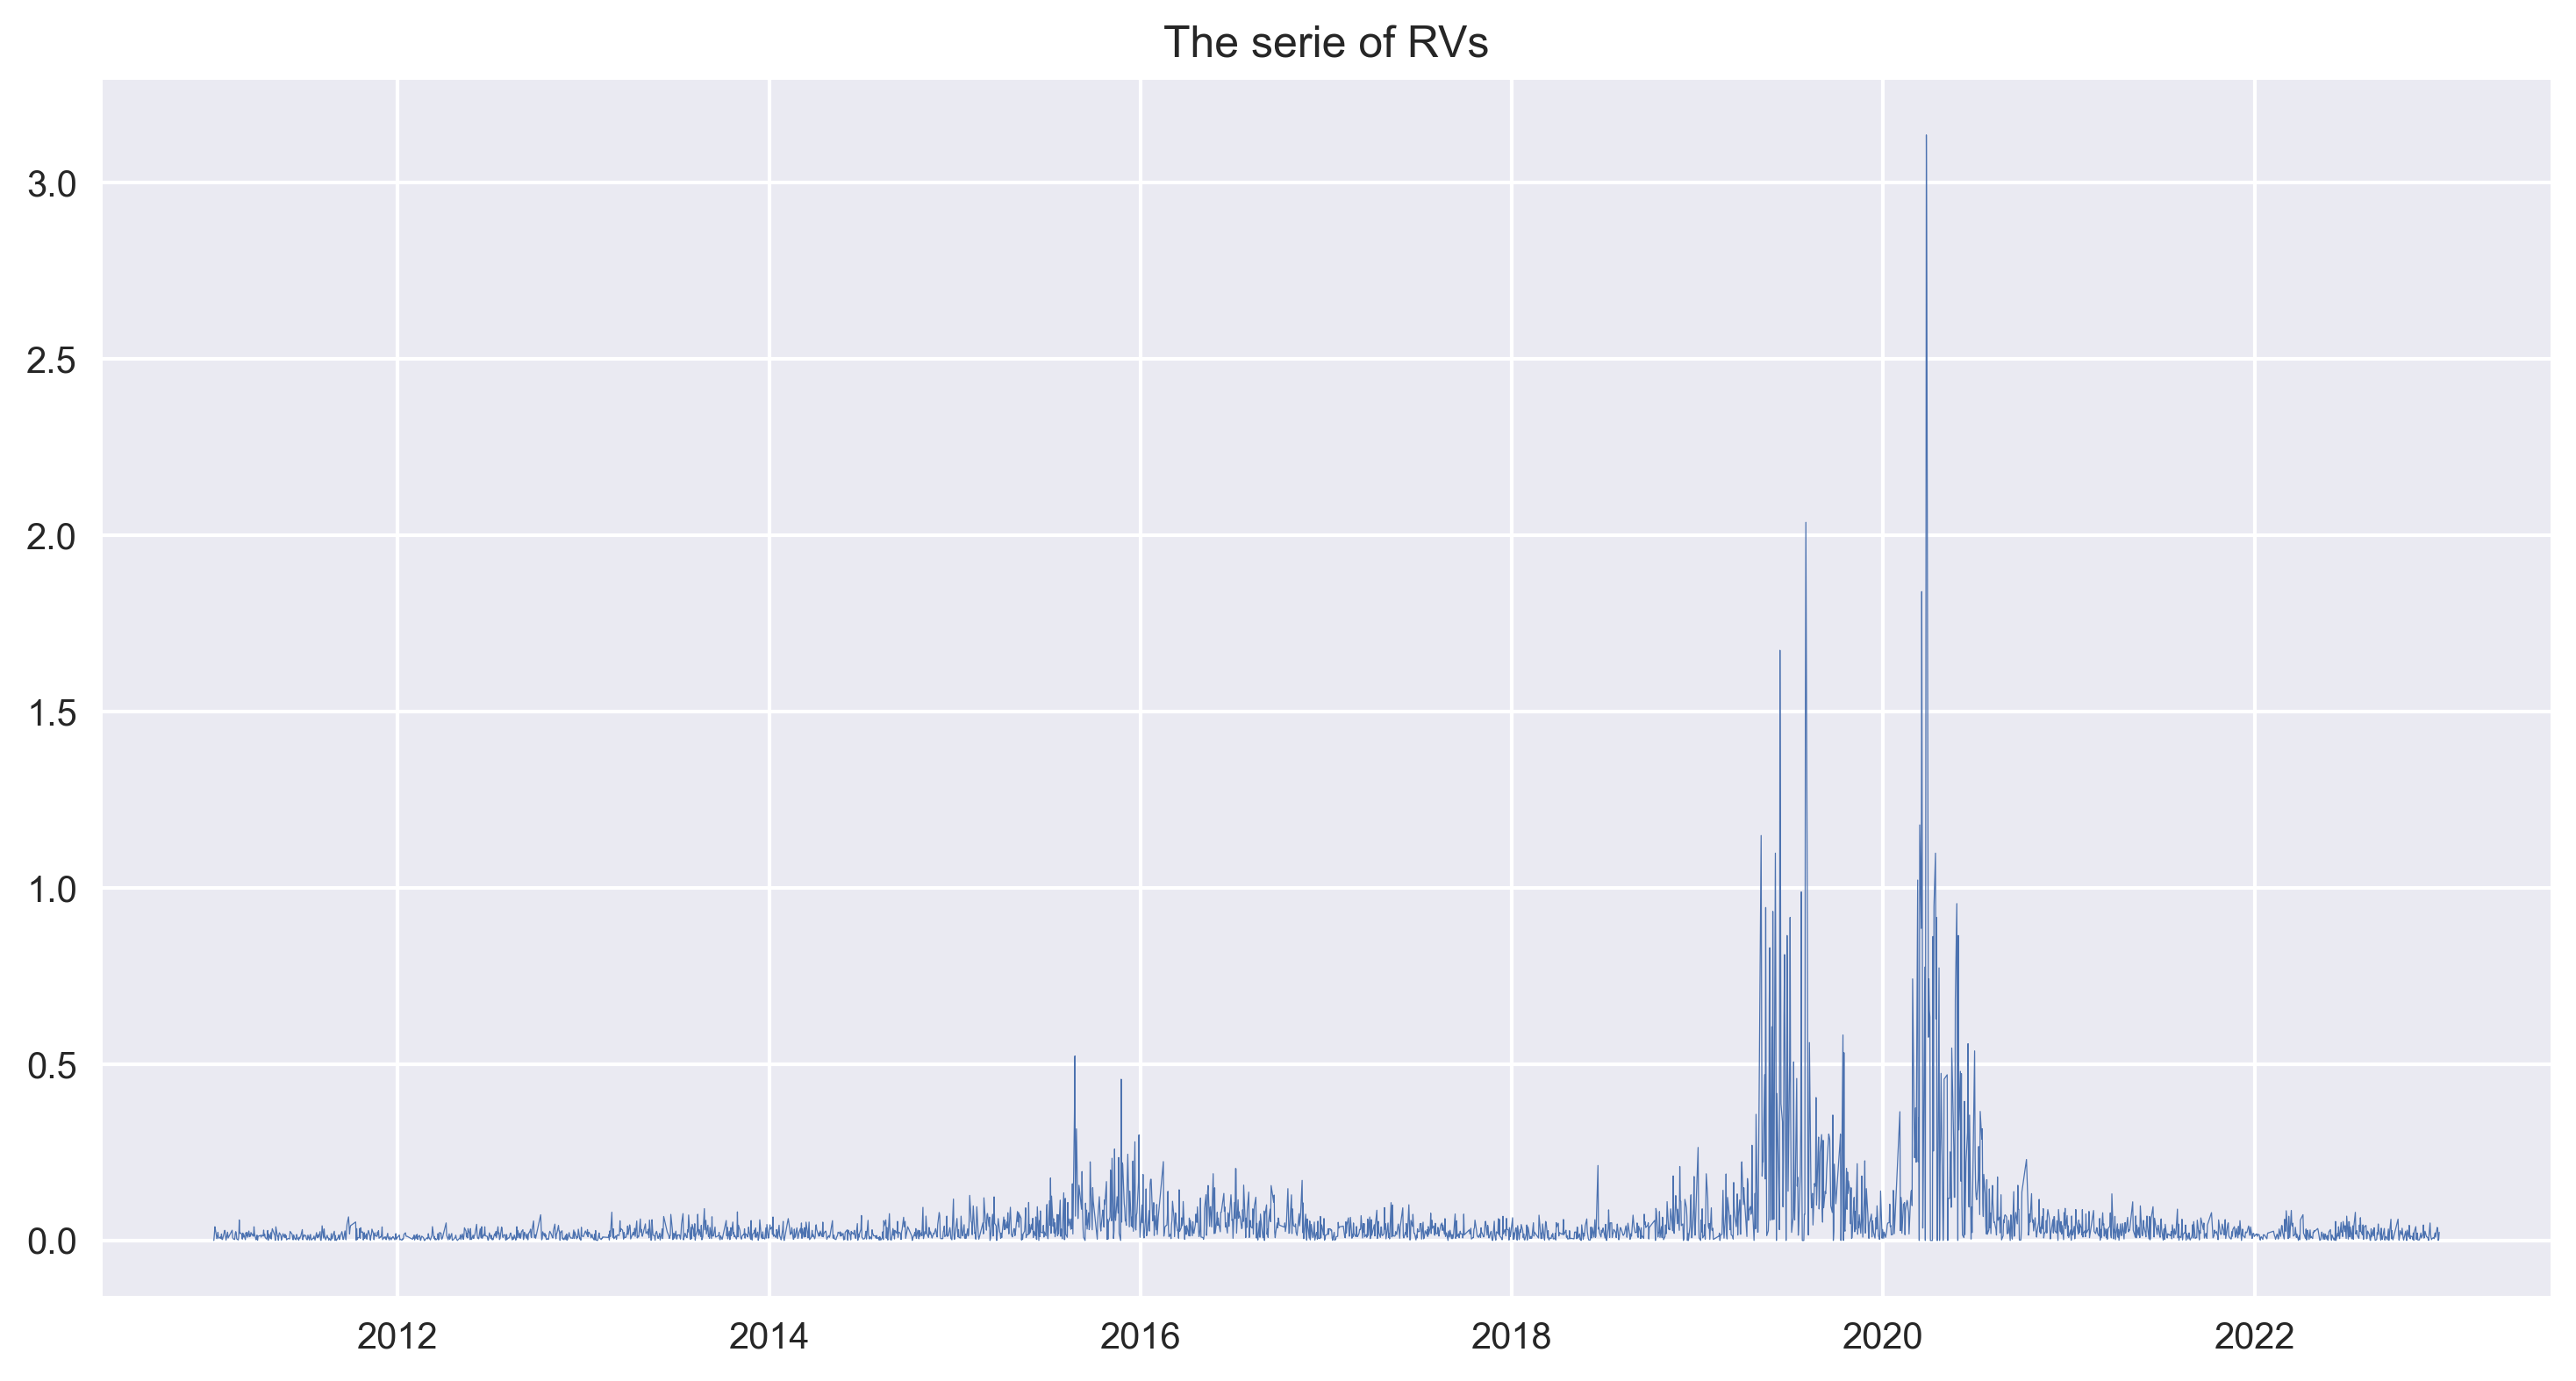

In [9]:
plt.plot(data['RV'],linewidth = 0.3)
plt.title('The serie of RVs')

In [10]:
###基本统计特征 表1

#count mean std
RVs = data['RV']
print('count: ',len(RVs))
print('mean: ',np.mean(RVs))
print('std: ',np.std(RVs))

import scipy
from scipy import stats

#skewness 
print('skewness: ',scipy.stats.skew(RVs))
#excess kurtosis
print('excess kurtosis: ',scipy.stats.kurtosis(RVs))
#J-B
print('J-B: ',scipy.stats.jarque_bera(RVs).statistic)

import statsmodels.api as sm
#Q(10)
print('Q(10): ',sm.stats.acorr_ljungbox(RVs, lags=[10])['lb_stat'].values[0])

count:  2917
mean:  0.05687969622102948
std:  0.15013808662304395
skewness:  9.396407729884348
excess kurtosis:  129.2836077842159
J-B:  2074402.8128329657
Q(10):  5319.213670843754


In [11]:
scipy.__version__

'1.9.1'

In [12]:
import statsmodels
statsmodels.__version__

'0.13.5'

### CEEMDAN分解和可视化

In [13]:
from PyEMD import CEEMDAN, Visualisation

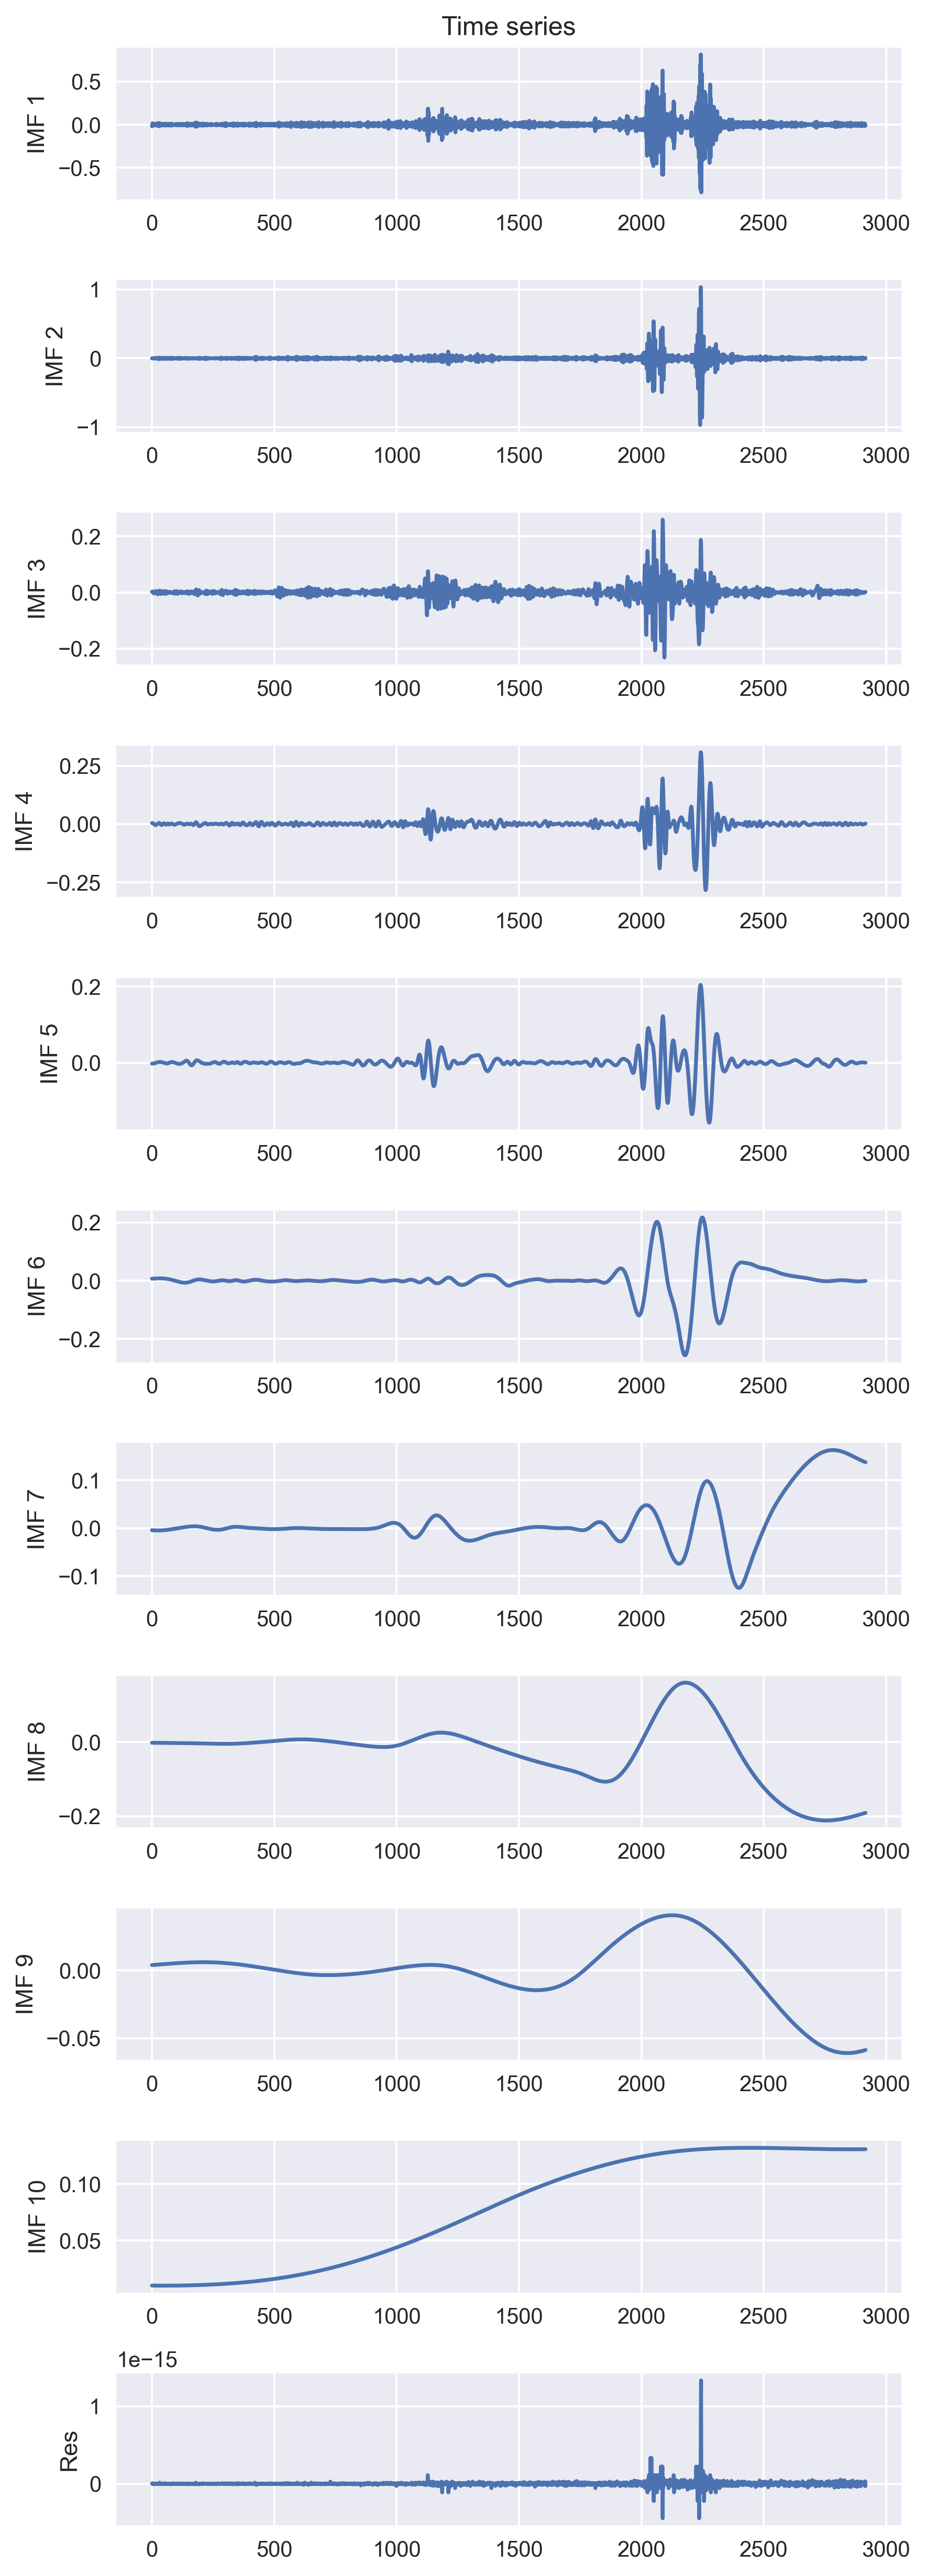

In [14]:
#Decomposition results of RV for stock indices.

ceemdan = CEEMDAN()
ceemdan.ceemdan(RVs.values.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, len(RVs), 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [15]:
decompose_data = pd.DataFrame(np.vstack((imfs_close, res_close)).T,columns = ['IMF%d'%(i+1) for i in range(len(imfs_close))] + ['Res'])
de_count = decompose_data.apply(len).values
de_mean = decompose_data.apply(np.mean).values
de_std = decompose_data.apply(np.std).values
de_skew = decompose_data.apply(scipy.stats.skew).values
de_kurtosis = decompose_data.apply(scipy.stats.kurtosis).values
de_jb = decompose_data.apply(lambda x: scipy.stats.jarque_bera(x).statistic).values
de_Q = decompose_data.apply(lambda x: sm.stats.acorr_ljungbox(x, lags=[10])['lb_stat'].values[0]).values

In [16]:
de_data_feature = np.vstack((de_count,de_mean,de_std,de_skew,de_kurtosis,de_jb,de_Q)).T
decompose_data_feature = pd.DataFrame(de_data_feature,columns = ['count','mean','std','skew','kurtosis','J-B','Q(10)'],index = decompose_data.columns)

#表2
decompose_data_feature

,count,mean,std,skew,kurtosis,J-B,Q(10)
IMF1,2917.0,-2.842732e-03,7.464295e-02,0.037797,33.401544,1.356003e+05,632.368047
IMF2,2917.0,-1.192924e-03,6.685241e-02,-0.954150,89.215336,9.678384e+05,3736.824770
IMF3,2917.0,-6.848379e-04,2.693805e-02,-0.220189,25.988815,8.211506e+04,6741.127971
IMF4,2917.0,-2.518137e-04,3.538708e-02,-0.079221,30.056212,1.098009e+05,10864.366390
IMF5,2917.0,2.724548e-04,2.895470e-02,0.458983,16.728450,3.411477e+04,19321.202618
IMF6,2917.0,1.780688e-03,5.278152e-02,-0.516009,8.720327,9.371976e+03,27713.490066
IMF7,2917.0,1.365098e-02,5.480797e-02,1.144173,1.810883,1.035028e+03,28778.362163
IMF8,2917.0,-3.004526e-02,8.540810e-02,-0.392574,0.320947,8.744490e+01,29008.640906
IMF9,2917.0,-1.708605e-03,2.355624e-02,-0.727490,0.910480,3.580543e+02,28899.907747
IMF10,2917.0,7.790175e-02,4.779431e-02,-0.197097,-1.629446,3.415906e+02,29066.917356


## 建模

### 直接lstm

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from keras.callbacks import EarlyStopping

# 调用GPU加速
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

call_backs = [EarlyStopping(monitor='val_loss', patience=10)]

2023-03-22 15:58:06.110626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:

#定义时间序列划分函数
def TimeSeries(dataset, start_index, history_size, end_index, step,
               target_size, point_time, true):
    data = []  # 保存特征数据
    labels = []  # 保存特征数据对应的标签值

    start_index = start_index + history_size  # 第一次的取值范围[0:start_index]

    # 如果没有指定滑动窗口取到哪个结束，那就取到最后
    if end_index is None:
        # 数据集最后一块是用来作为标签值的，特征不能取到底
        end_index = len(dataset) - target_size

    # 滑动窗口的起始位置到终止位置每次移动一步
    for i in range(start_index, end_index):

        index = range(i - history_size, i, step)  # 第一次相当于range(0, start_index, 6)

        # 根据索引取出所有的特征数据的指定行
        data.append(dataset.iloc[index])
        # 用这些特征来预测某一个时间点的值还是未来某一时间段的值
        if point_time is True:  # 预测某一个时间点
            # 预测未来哪个时间点的数据，例如[0:20]的特征数据（20取不到），来预测第20个的标签值
            labels.append(true[i + target_size])

        else:  # 预测未来某一时间区间
            # 例如[0:20]的特征数据（20取不到），来预测[20,20+target_size]数据区间的标签值
            labels.append(true[i:i + target_size])

    # 返回划分好了的时间序列特征及其对应的标签值
    return np.array(data), np.array(labels)


#按照7:2:1划分训练验证测试集
def get_tain_val_test(serie_data,window_size):
    train_num = int(len(serie_data)*0.7)
    val_num = int(len(serie_data)*0.9)  # 取2w-2.3w的数据用于验证
    history_size = window_size  # 每个滑窗取5-26-272天的数据量(表示短期中期长期预测)
    target_size =  0  # 预测未来下一个时间点的气温值
    step = 1  # 步长为1取所有的行

    # 求训练集的每个特征列的均值和标准差
    feat_mean = serie_data.mean(axis=0)
    feat_std = serie_data.std(axis=0)

    # 对整个数据集计算标准差
    feat = (serie_data - feat_mean) / feat_std

    # 构造训练集
    x_train, y_train = TimeSeries(dataset=serie_data, start_index=0, history_size=history_size, end_index=train_num,
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造验证集
    x_val, y_val = TimeSeries(dataset=serie_data, start_index=train_num, history_size=history_size, end_index=val_num,
                              step=step, target_size=target_size, point_time=True, true=serie_data)

    # 构造测试集
    x_test, y_test =  TimeSeries(dataset=serie_data, start_index=val_num, history_size=history_size, end_index=len(serie_data),
                                  step=step, target_size=target_size, point_time=True, true=serie_data)

    # 查看数据集信息
    #print('x_train_shape:', x_train.shape)
    #print('y_train_shape:', y_train.shape)
    return x_train,y_train,x_val, y_val,x_test, y_test


import numpy as np
import pandas as pd
import math
# import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

def implement_LSTM(X_train, y_train,X_validate,y_validate,verbose = 0, model_summary = False):
    model = Sequential()
    model.add(LSTM(30, input_shape=(None,1)))
    model.add(Dense(1))
    if model_summary:
        model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
#     model.compile(loss='mean_squared_error', optimizer='sgd')
    history = model.fit(X_train, y_train, epochs=20,validation_data=(X_validate,y_validate), batch_size=16, verbose=verbose)
    print('finished training')
    return history,model

In [19]:
window_size = 26
x_train_all,y_train_all,x_val_all, y_val_all,x_test_all, y_test_all = get_tain_val_test(RVs,window_size)
history,model = implement_LSTM(x_train_all, y_train_all, x_val_all, y_val_all)
y_pre_all = model.predict(x_test_all).reshape(-1)

2023-03-22 15:58:25.192563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


finished training
9/9 [==============================] - 1s 7ms/step


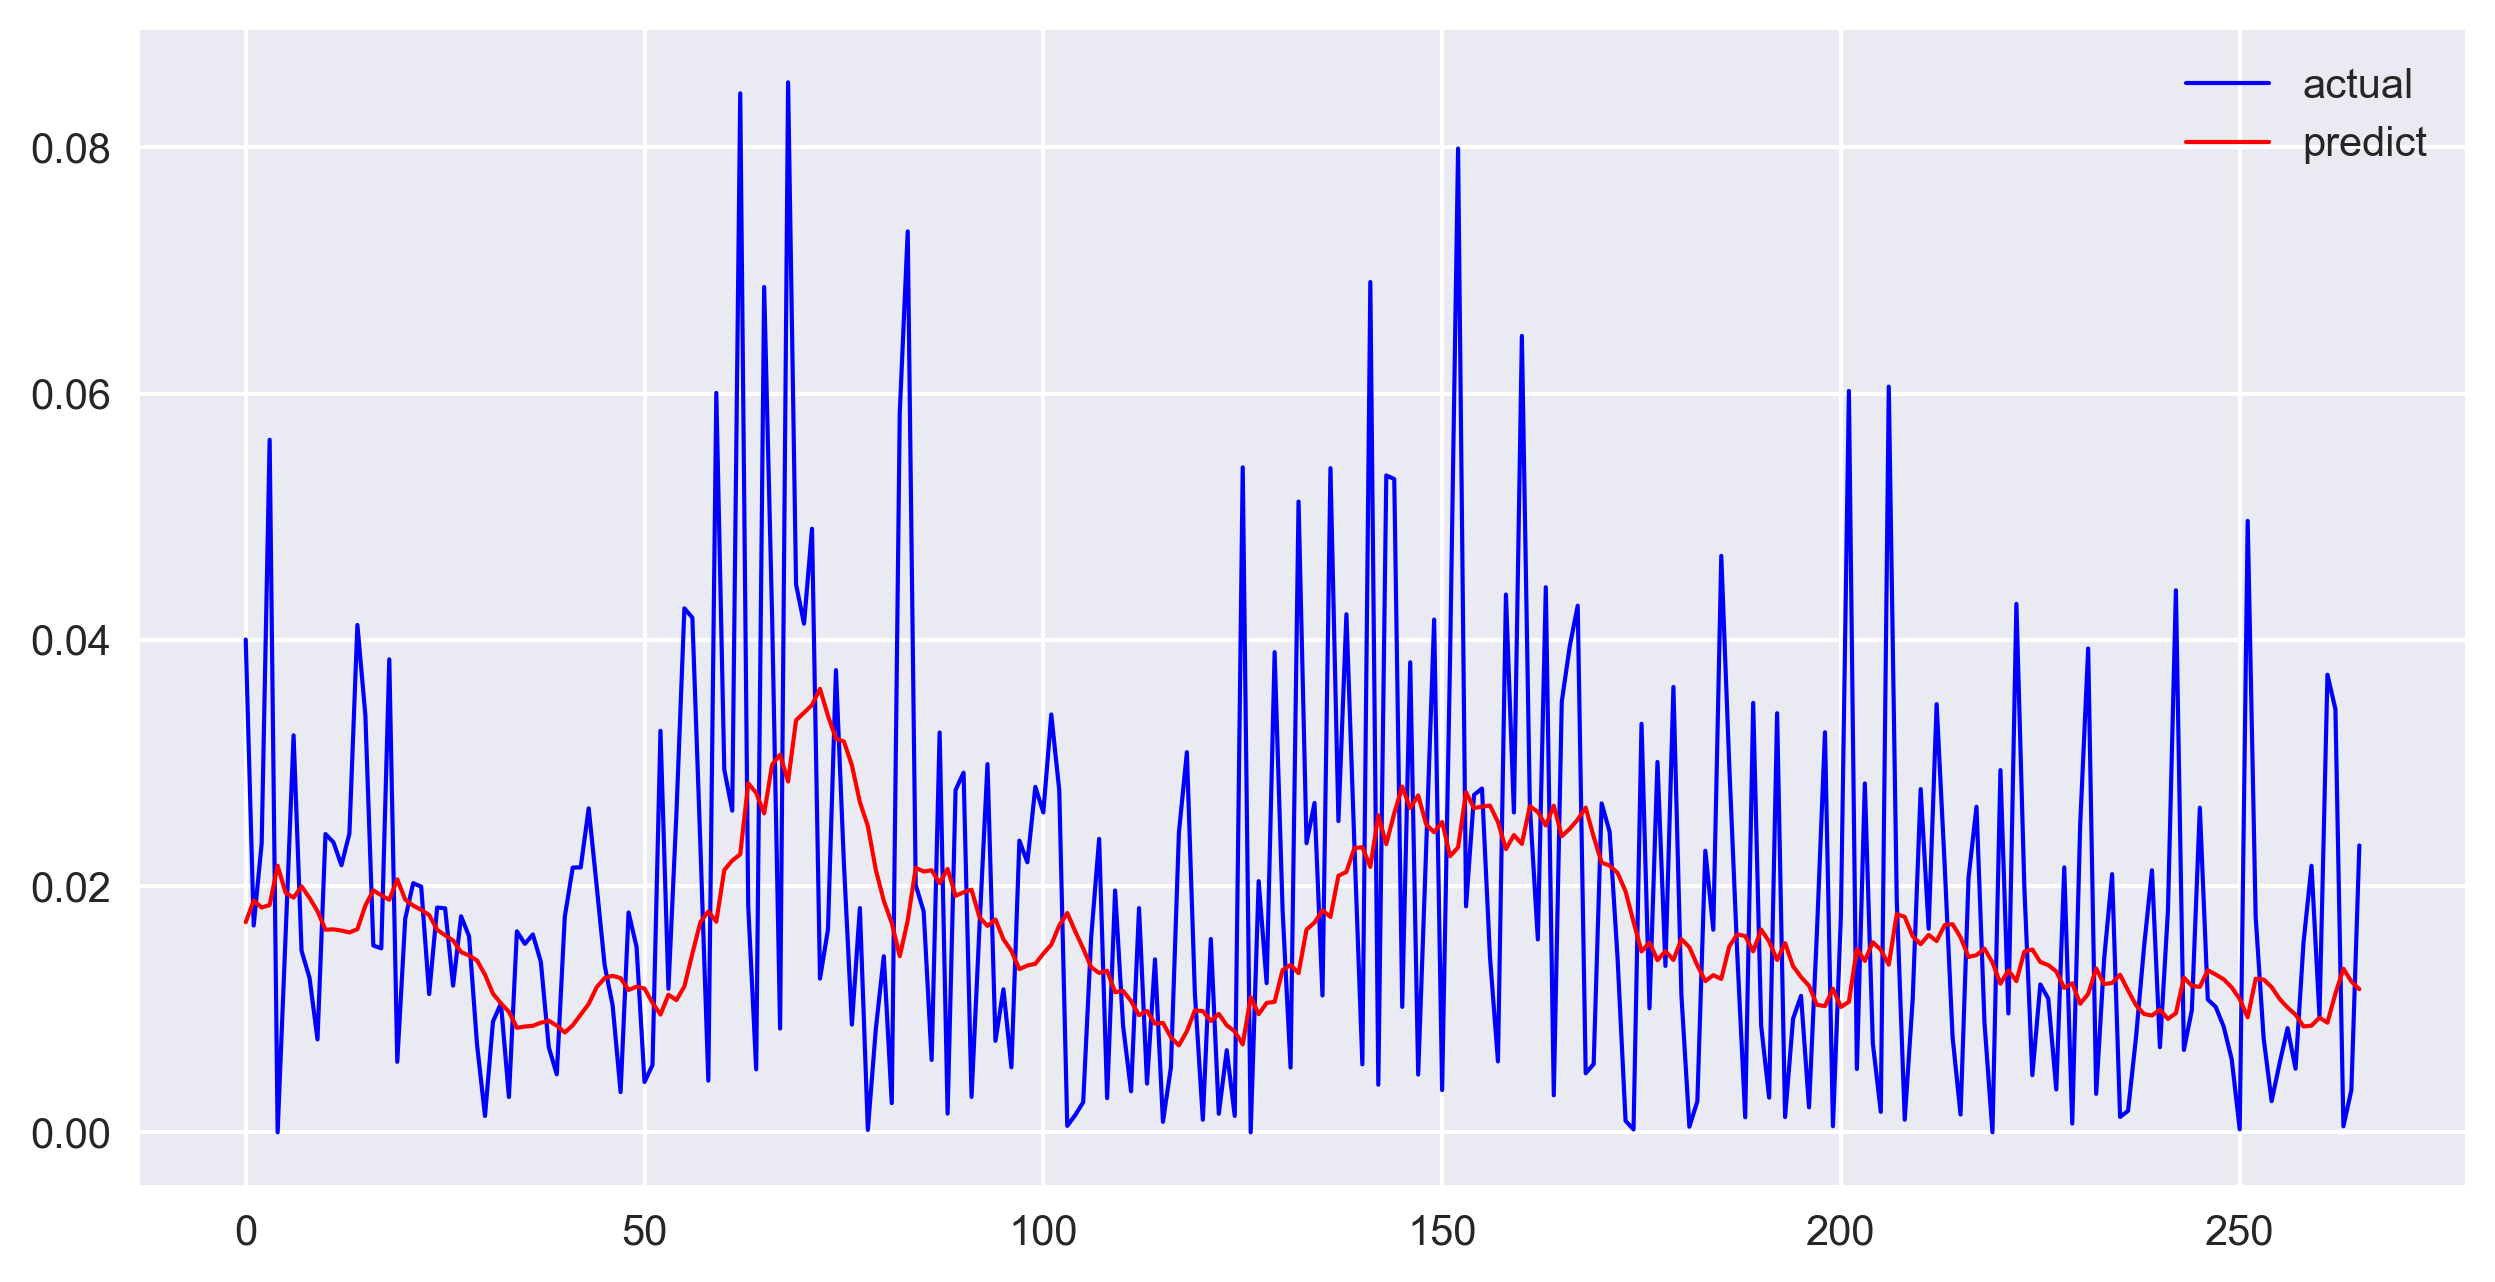

In [20]:
#history_dict = history.history  # 获取训练的数据字典
#train_loss = history_dict['loss']  # 训练集损失
#val_loss = history_dict['val_loss']  # 验证集损失

#（11）绘制训练损失和验证损失
#plt.figure()
#plt.plot(range(20)[:len(train_loss)], train_loss, label='train_loss')  # 训练集损失
#plt.plot(range(20)[:len(train_loss)], val_loss, label='val_loss')  # 验证集损失
#plt.legend()  # 显示标签
#plt.xlabel('epochs')
#plt.ylabel('loss')
#plt.show()
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_test_all, 'b-',linewidth = '1', label='actual')
axes.plot(y_pre_all, 'r-', linewidth = '1', label='predict')

plt.legend()
#plt.grid()
plt.show()

In [21]:
def mean_absolute_error(y_test,y_pre):
    mae = np.sum(np.absolute(y_pre-y_test))/len(y_test)
    return mae
def mean_squared_error(y_test,y_pre):
    mse = np.sum((y_pre-y_test)**2)/len(y_test)
    return mse
def h_mean_absolute_error(y_test,y_pre):
    hmae = mean_absolute_error(y_test,y_pre) / np.mean(y_pre)
    return hmae
def h_mean_squared_error(y_test,y_pre):
    hmse = mean_squared_error(y_test,y_pre) / np.mean(y_pre) ** 2
    return hmse

In [22]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_all))
print("MSE:", mean_squared_error(y_test_all, y_pre_all))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_all))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_all))

MAE: 0.012680076473224777
MSE: 0.00028936927789350106
HMAE: 0.7775086676305357
HMSE: 1.0879755946520424


### deecman+lstm

In [23]:
y_pre_list = []
y_test_list = []
for column in decompose_data.columns:
    serie_data = decompose_data[column]
    x_train,y_train,x_val, y_val,x_test, y_test = get_tain_val_test(serie_data,window_size)
    history,model = implement_LSTM(x_train, y_train, x_val, y_val)
    y_pre = model.predict(x_test)
    y_pre_list.append(y_pre)
    y_test_list.append(y_test)

finished training
9/9 [==============================] - 1s 8ms/step
finished training
9/9 [==============================] - 1s 7ms/step
finished training
9/9 [==============================] - 1s 8ms/step
finished training
9/9 [==============================] - 1s 9ms/step
finished training
9/9 [==============================] - 1s 7ms/step
finished training
9/9 [==============================] - 1s 8ms/step
finished training
9/9 [==============================] - 2s 10ms/step
finished training
9/9 [==============================] - 1s 6ms/step
finished training
9/9 [==============================] - 1s 7ms/step
finished training
9/9 [==============================] - 1s 7ms/step
finished training
9/9 [==============================] - 1s 7ms/step


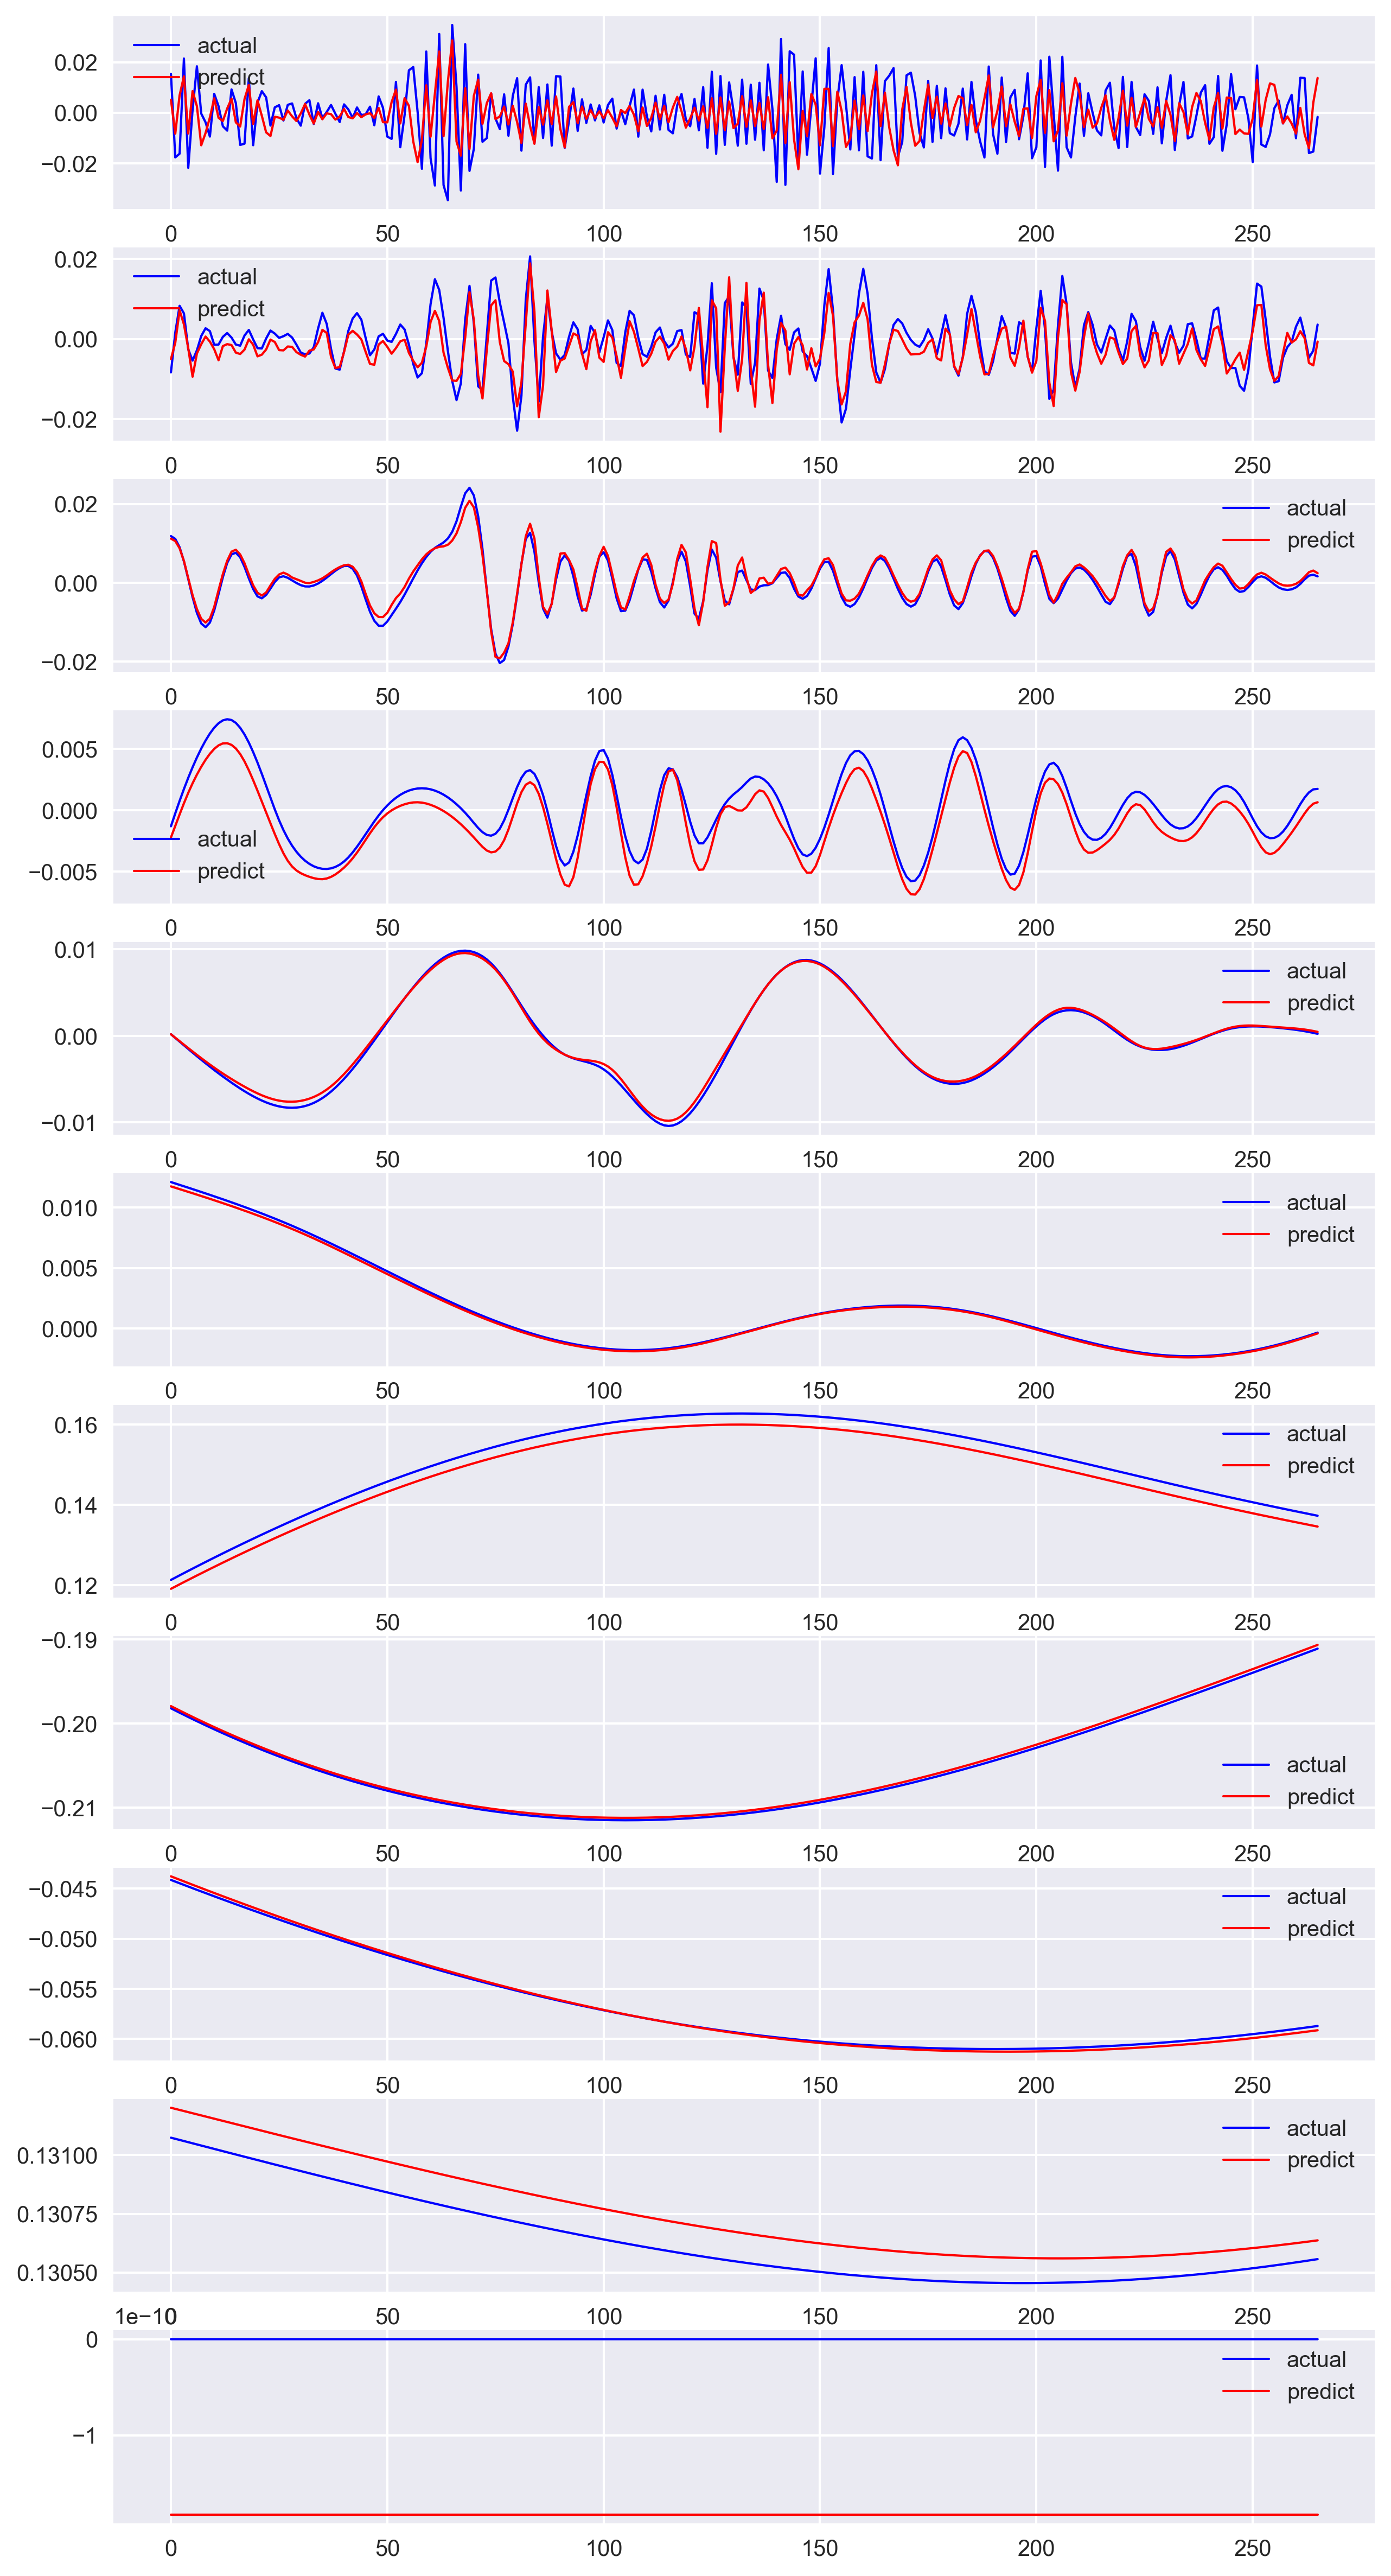

In [24]:
fig = plt.figure(figsize=(10,20))
for i,column in enumerate(decompose_data.columns):
    
    axes = fig.add_subplot(len(decompose_data.columns),1,i+1)
    axes.plot(y_test_list[i], 'b-',linewidth = '1', label='actual')
    axes.plot(y_pre_list[i], 'r-', linewidth = '1', label='predict')

    plt.legend()

In [25]:
#此时的预测是对全部分解结果的预测求和
y_pre_total = np.sum(np.array(y_pre_list),axis = 0).reshape(-1)

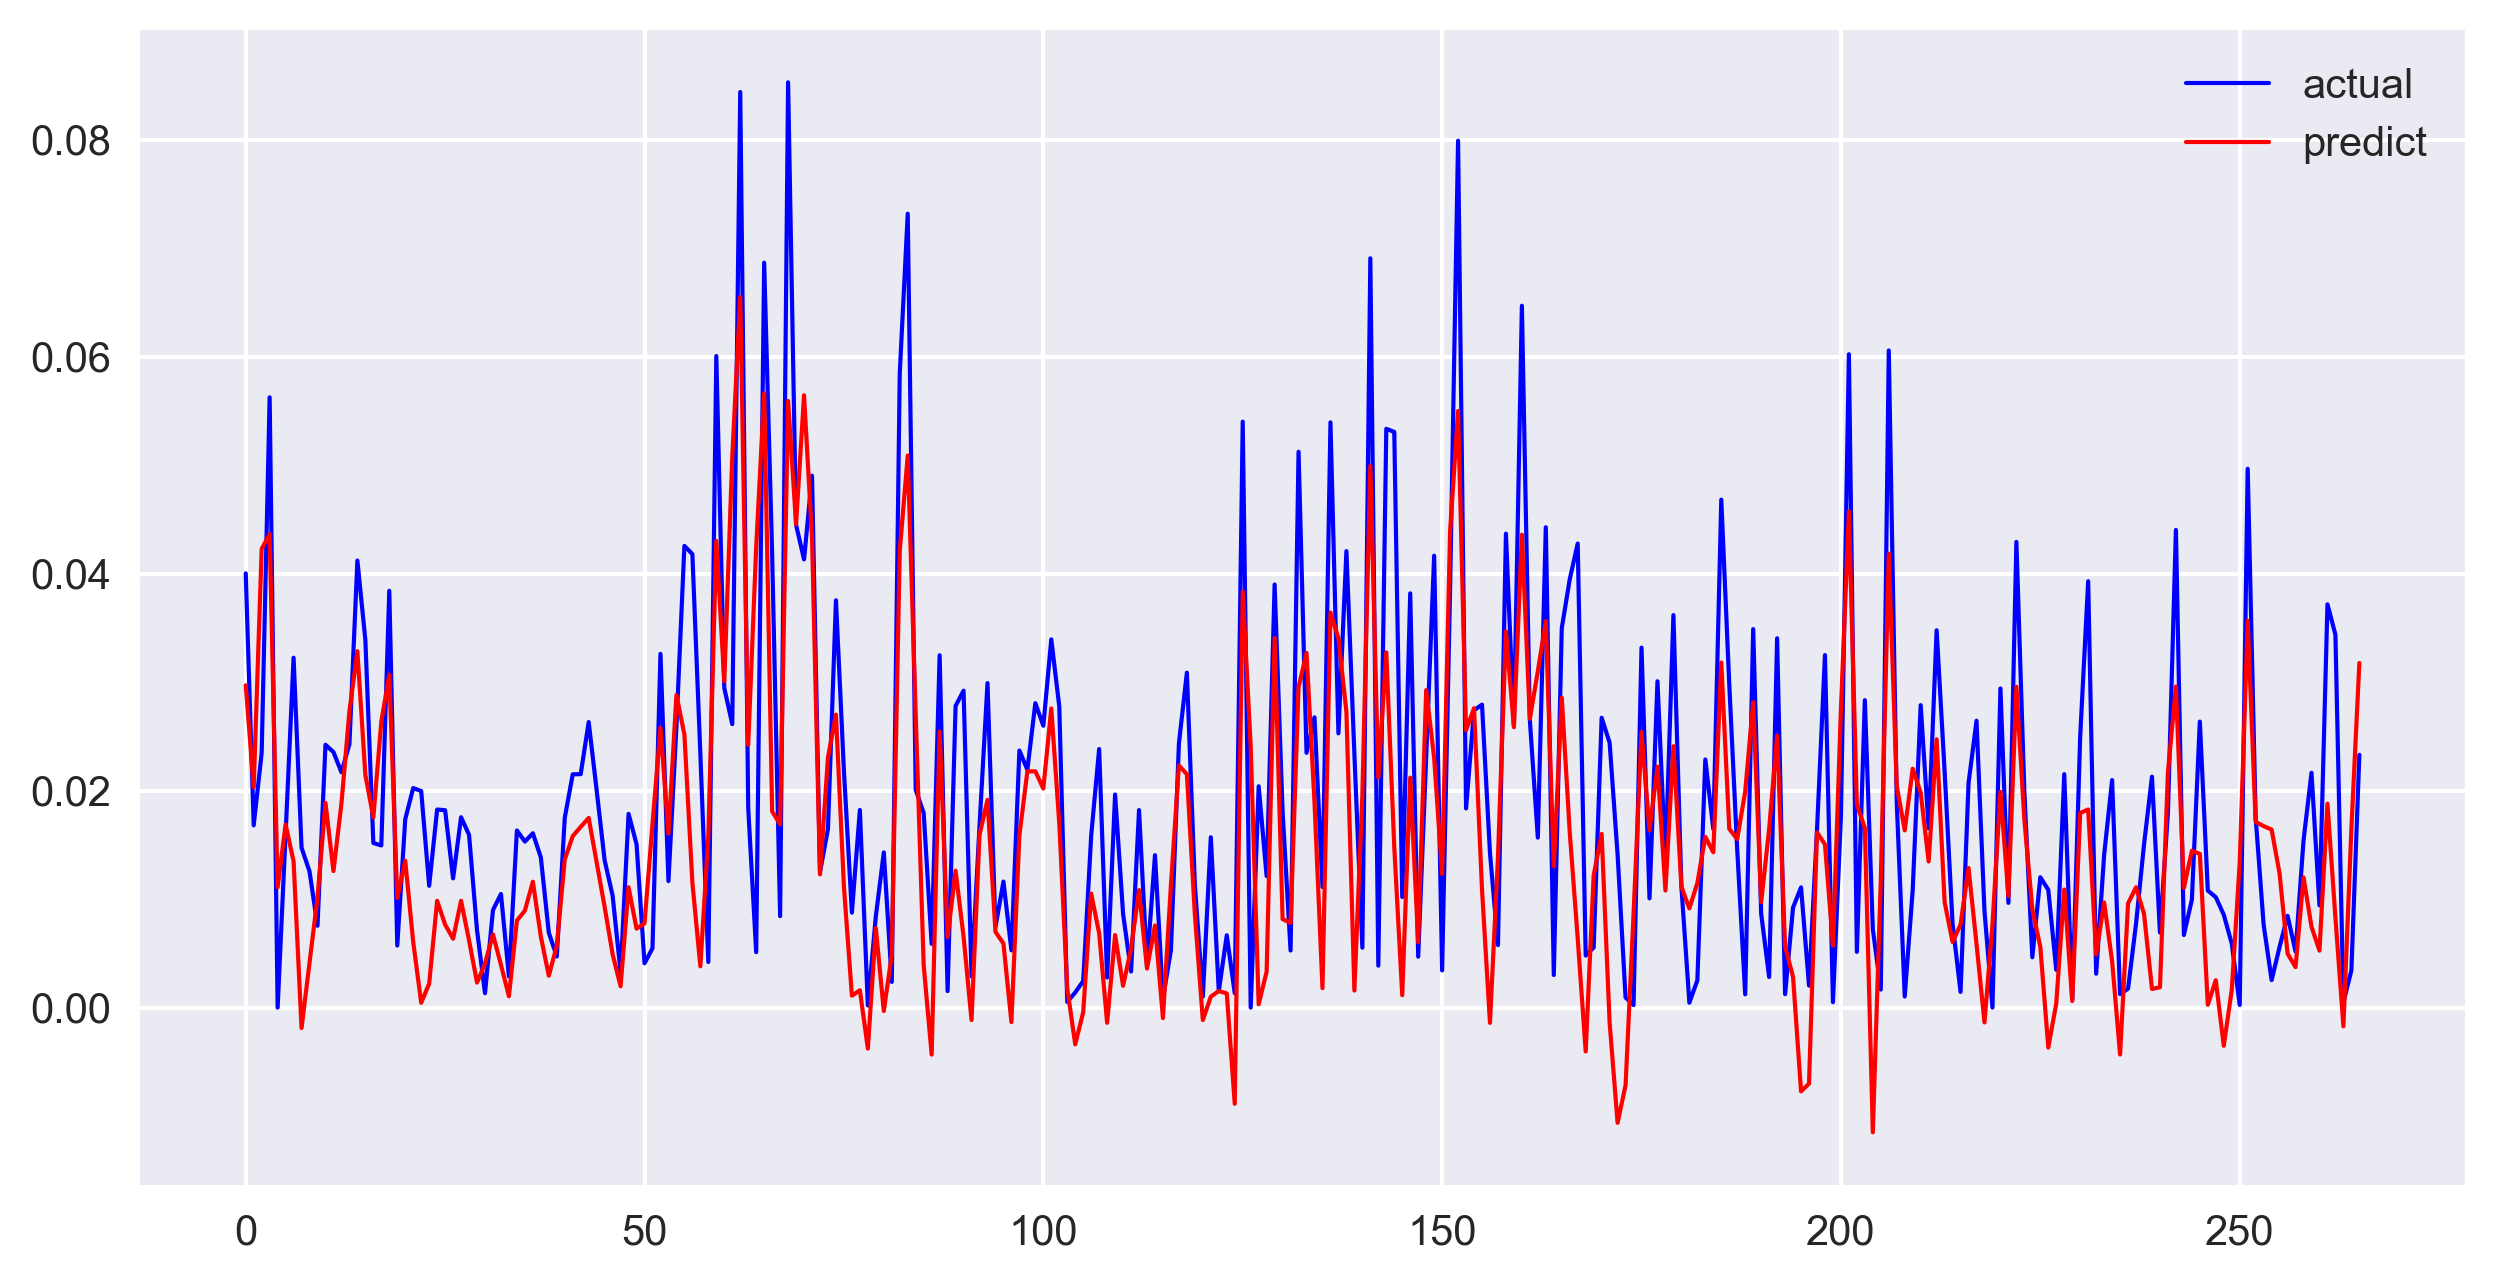

In [26]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_test_all, 'b-',linewidth = 1, label='actual')
axes.plot(y_pre_total, 'r-', linewidth = 1, label='predict')

plt.legend()
#plt.grid()
plt.show()

In [27]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_total))
print("MSE:", mean_squared_error(y_test_all, y_pre_total))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_total))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_total))

MAE: 0.009525851209523916
MSE: 0.00014101725660469713
HMAE: 0.6308291117642432
HMSE: 0.6184265530226896


## 其他模型
#### svr

In [28]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train_all, y_train_all)
y_pre_all_svr = svr.predict(x_test_all)

In [29]:
y_pre_all_svr1 = svr.predict(x_train_all)
y_pre_all_svr2 = svr.predict(x_val_all)
y_pre_all_svr3 = svr.predict(x_test_all)
y_pre_all_svr = np.hstack((y_pre_all_svr1,y_pre_all_svr2,y_pre_all_svr3))
y_all_label = np.hstack((y_train_all,y_val_all,y_test_all))

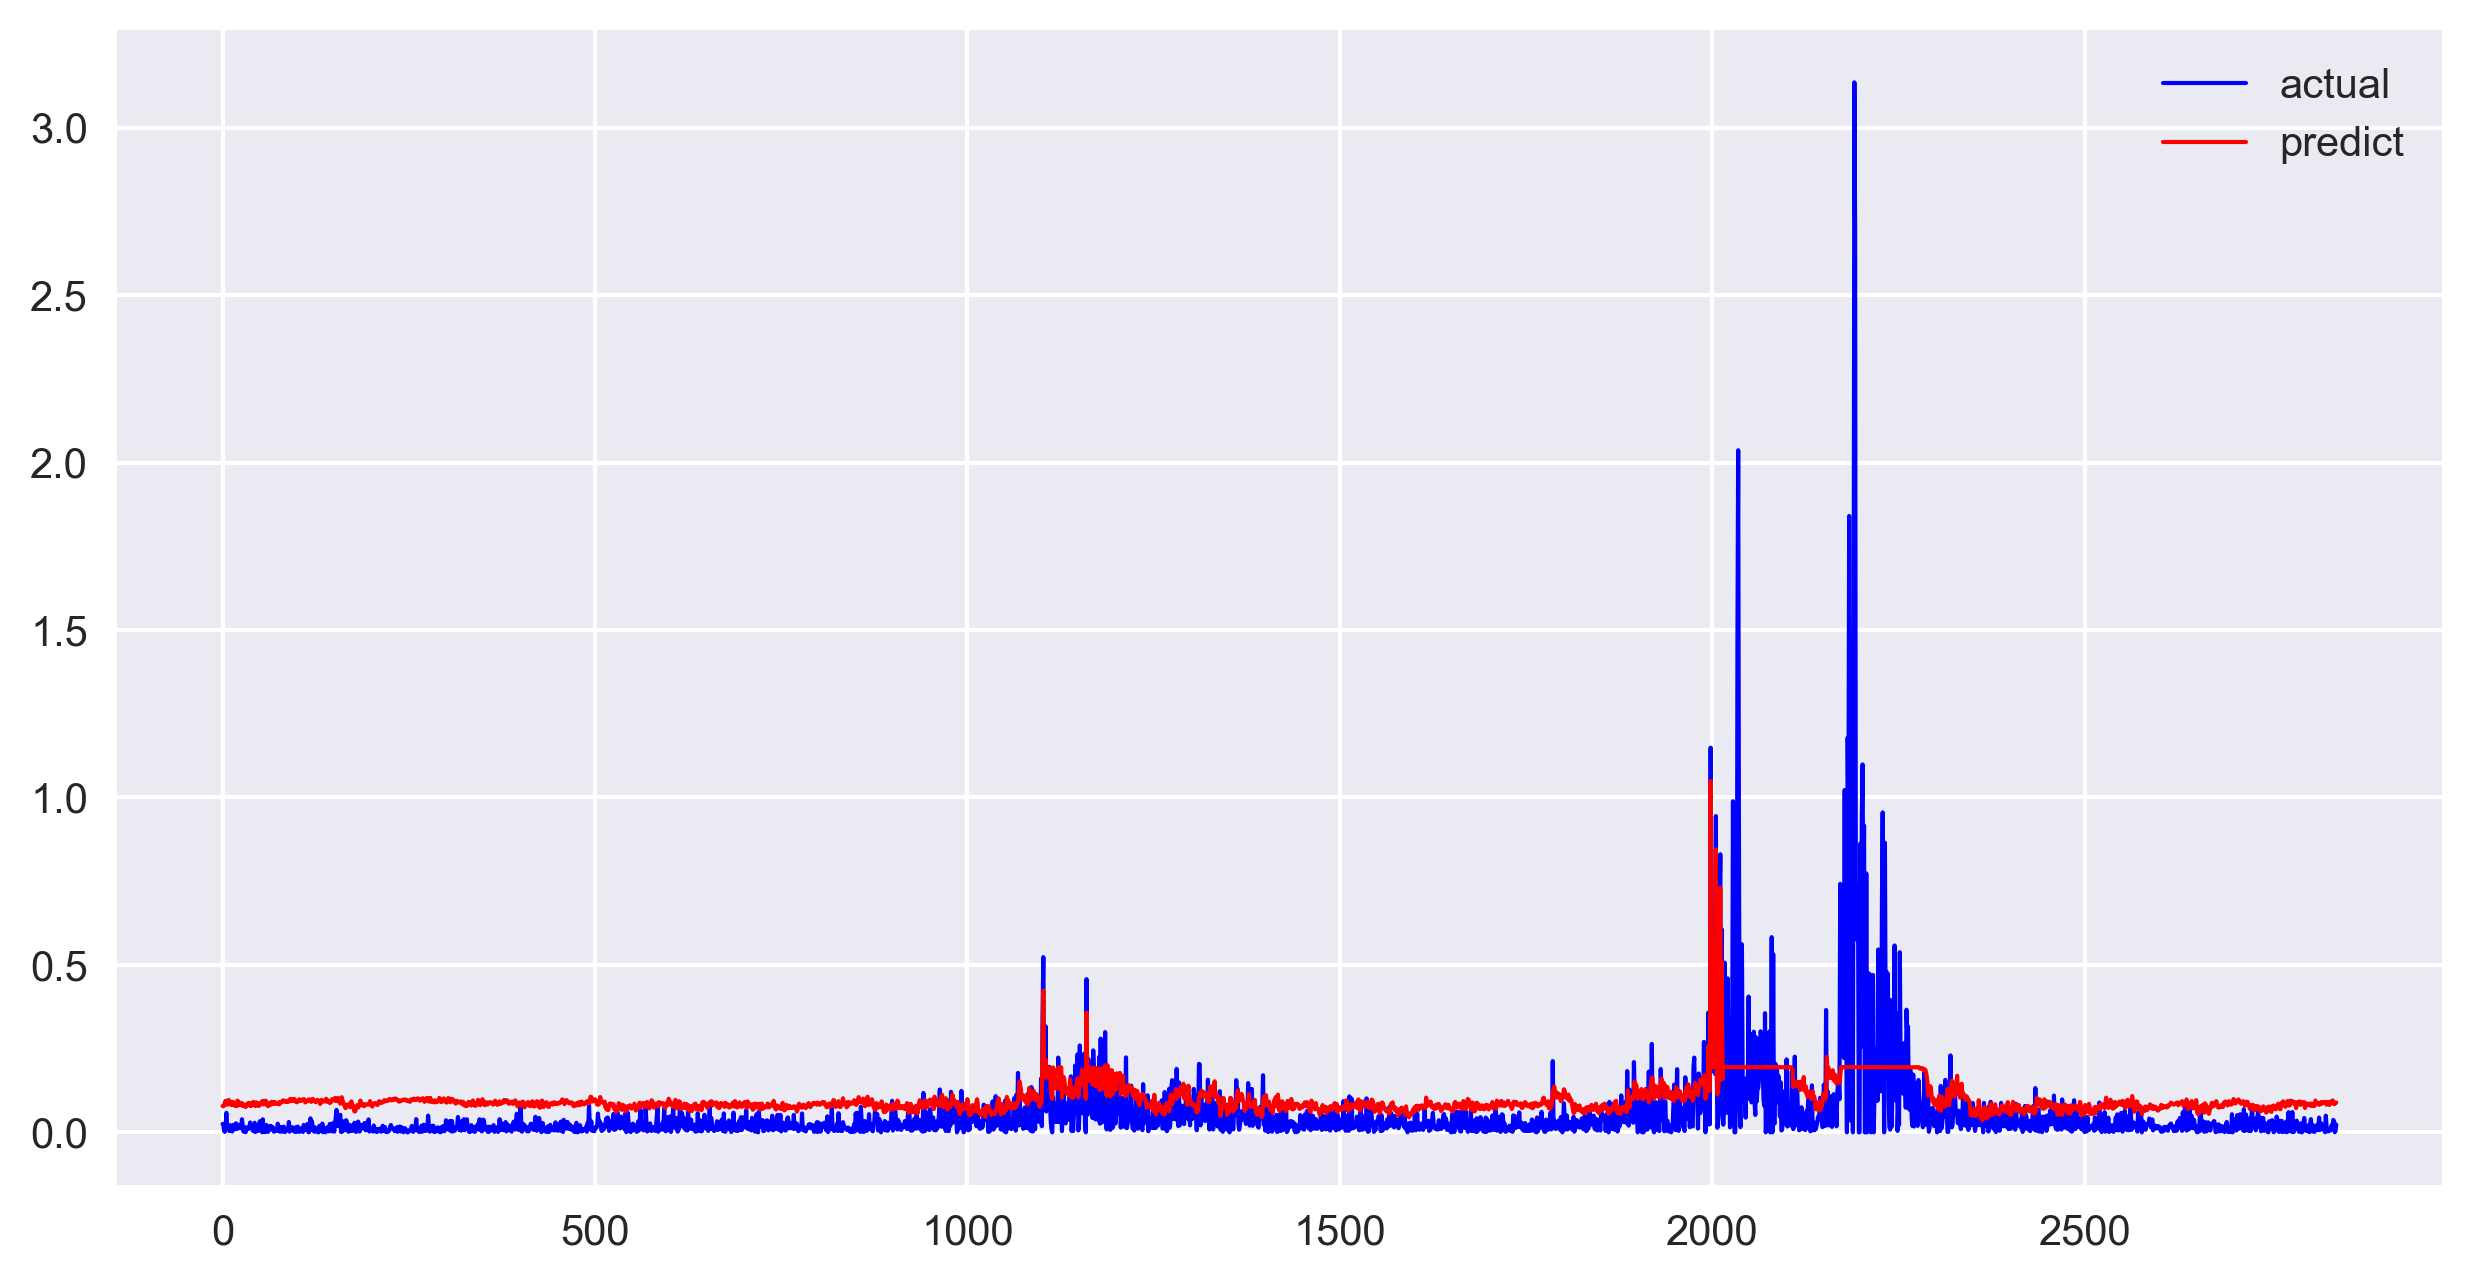

In [30]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_all_label, 'b-',linewidth = '1', label='actual')
axes.plot(y_pre_all_svr, 'r-', linewidth = '1', label='predict')

plt.legend()
#plt.grid()
plt.show()

In [31]:
print("MAE:", mean_absolute_error(y_test_all, y_pre_all_svr3))
print("MSE:", mean_squared_error(y_test_all, y_pre_all_svr3))
print("HMAE:", h_mean_absolute_error(y_test_all, y_pre_all_svr3))
print("HMSE:", h_mean_squared_error(y_test_all, y_pre_all_svr3))

MAE: 0.0605254713766086
MSE: 0.00400850069897182
HMAE: 0.7516971541542685
HMSE: 0.6182888503294248


#### ar

In [32]:
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
 
# 2阶AR模型拟合（OLS）
train_lenth = int(len(RVs)*0.9)
AR_model = AutoReg(RVs[:train_lenth], 2).fit()  
# 模型迭代预测后续个时间点的数据
predict_AR_1 = AR_model.predict(0,train_lenth).values
predict_AR_2 = AR_model.forecast(len(y_test_all)).values
predict_all_ar = np.hstack((predict_AR_1,predict_AR_2))
y_all_label = np.hstack((y_train_all,y_val_all,y_test_all))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


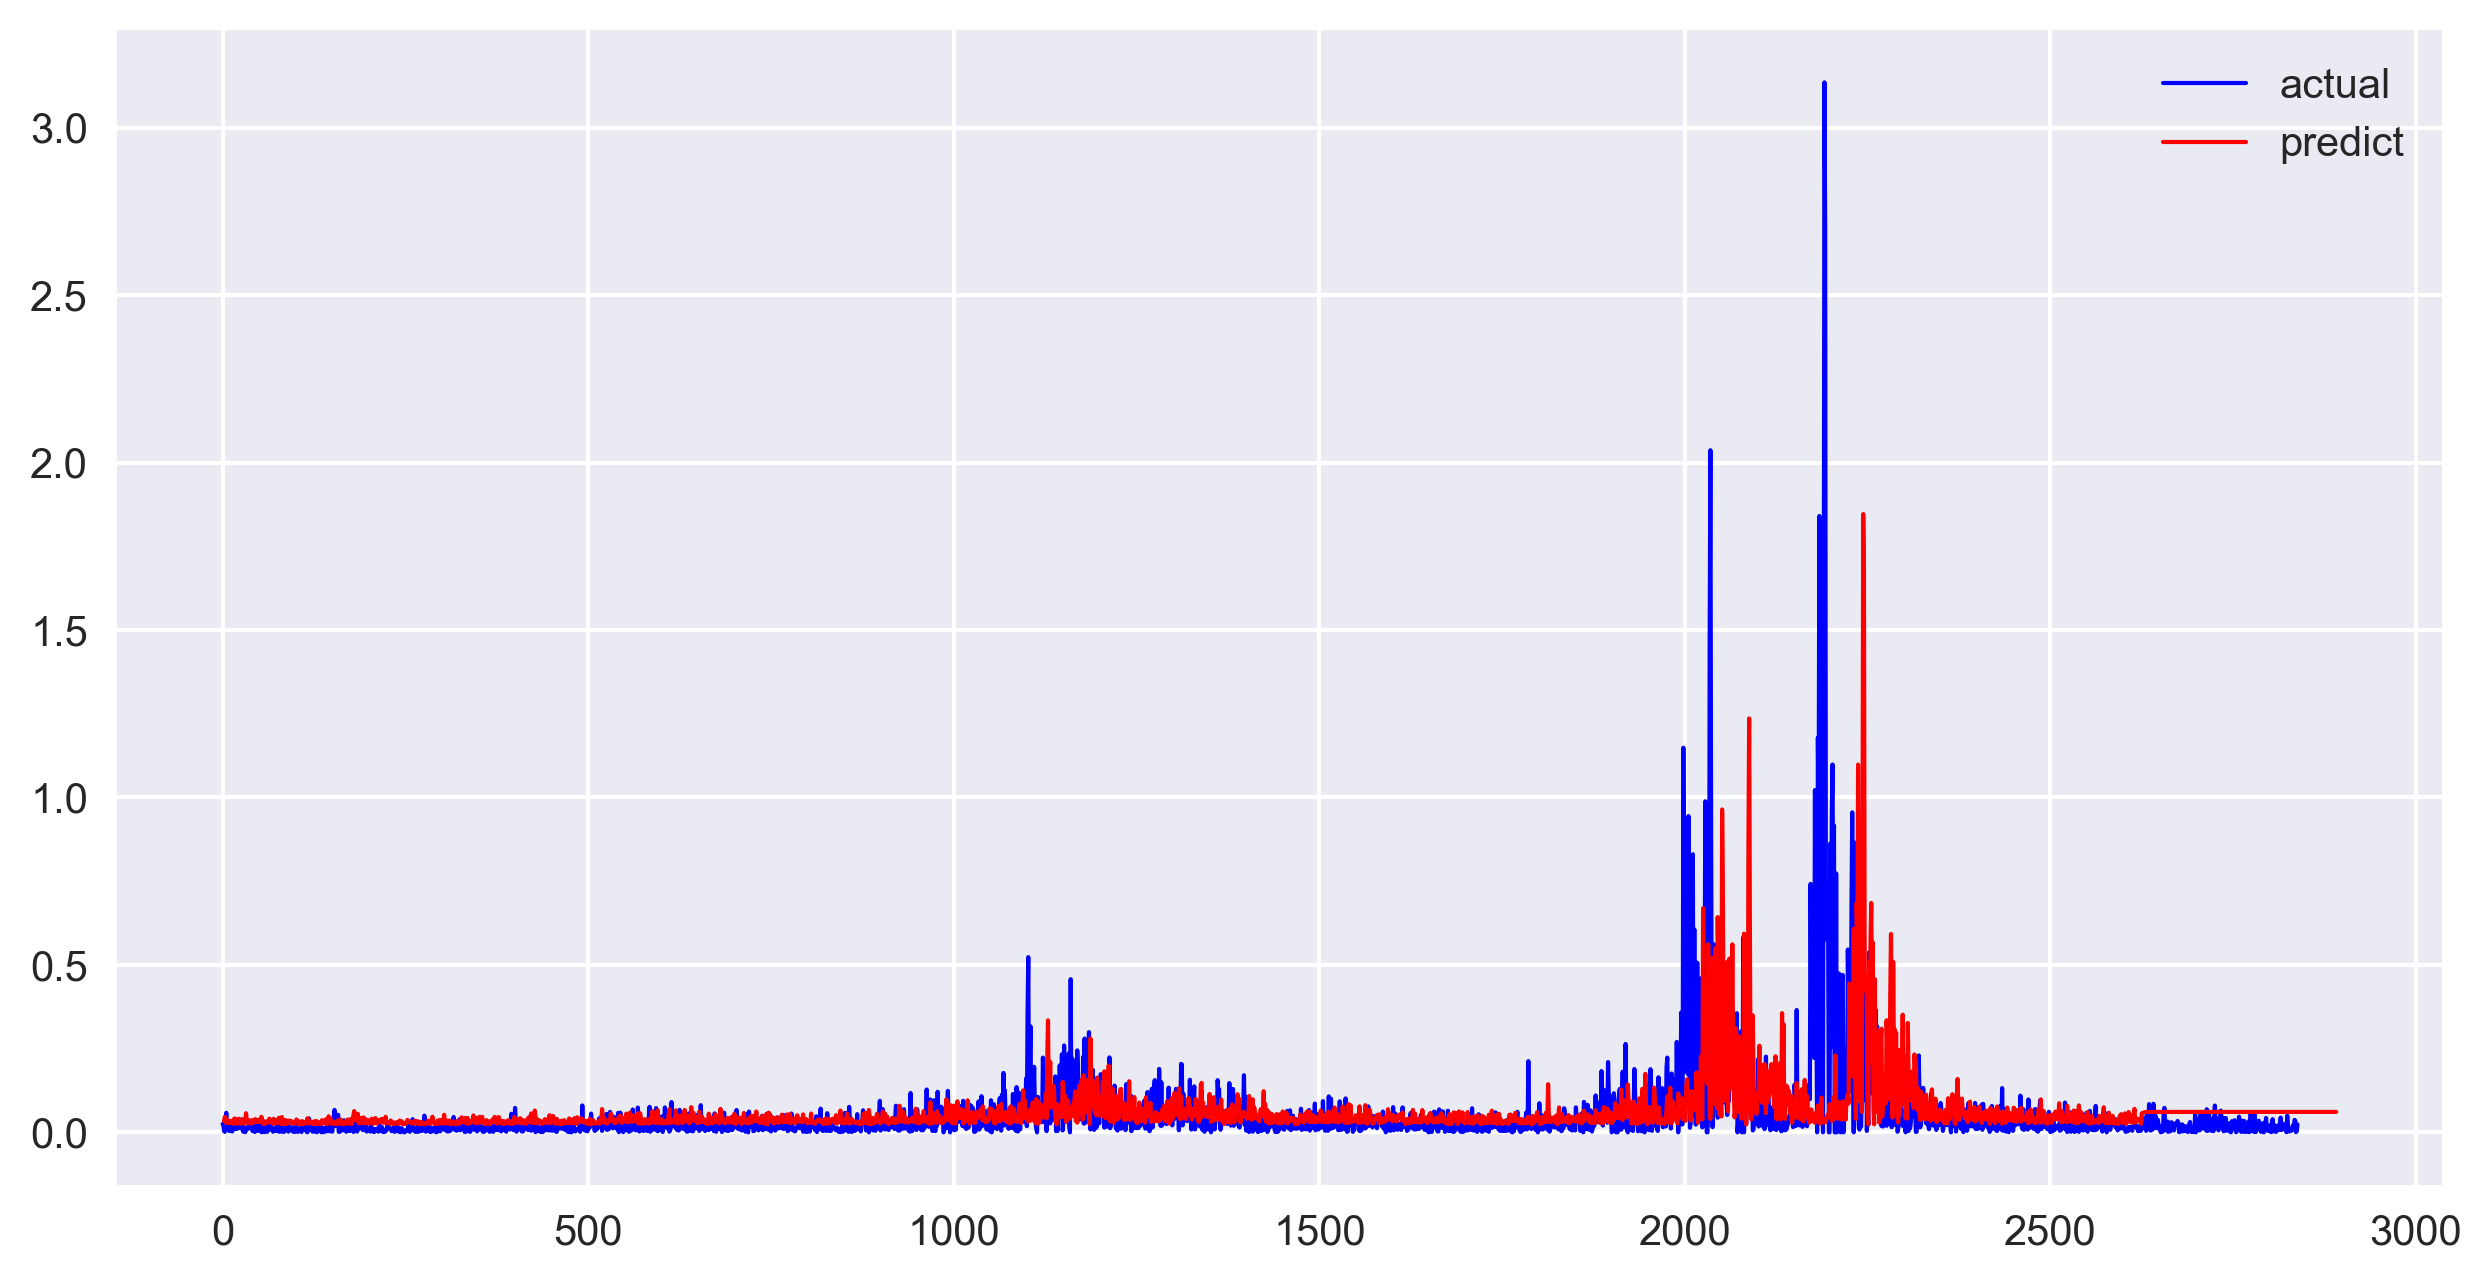

In [33]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_all_label, 'b-',linewidth = '1', label='actual')
axes.plot(predict_all_ar, 'r-', linewidth = '1', label='predict')

plt.legend()
#plt.grid()
plt.show()

In [34]:
print("MAE:", mean_absolute_error(y_test_all, predict_AR_2))
print("MSE:", mean_squared_error(y_test_all, predict_AR_2))
print("HMAE:", h_mean_absolute_error(y_test_all, predict_AR_2))
print("HMSE:", h_mean_squared_error(y_test_all, predict_AR_2))

MAE: 0.0416598866840211
MSE: 0.0019615938201514344
HMAE: 0.6834069915575002
HMSE: 0.5278757980548372


#### har

In [35]:
# Prepare data 
RVs_target = RVs.shift(-1) #We want to predict the RV of the next day.  
X = RVs[:-1]
y = RVs_target[:-1]
#Split train and test sets
split = int(0.90 * RVs.shape[0])
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

We can now train the parameters for HAR. $\hat{RV_{t+1d}^{d}} = \hat{\beta_0} + \hat{\beta_1} RV_t^d + \hat{\beta_2} RV_t^w + \hat{\beta_3} RV_t^m + \hat{\beta_4}IV_t + \hat{\beta_5}VOL_t $ 

We do this with OLS:
$\hat{\beta} = (X'X)^{-1}X'Y$

In [36]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     RV   R-squared (uncentered):                   0.413
Model:                            OLS   Adj. R-squared (uncentered):              0.412
Method:                 Least Squares   F-statistic:                              1843.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):                   1.75e-305
Time:                        16:09:26   Log-Likelihood:                          1640.2
No. Observations:                2625   AIC:                                     -3278.
Df Residuals:                    2624   BIC:                                     -3272.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RV             0.6423      0.015     42.930      0.000       0.613       0.672
==============================================================================
Omnibus:                     3121.470   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           680057.851
Skew:                           5.951   Prob(JB):                         0.00
Kurtosis:                      80.949   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For $\hat{\beta_3}$ (***RV_monthly***) and $\hat{\beta_5}$ (***SPY_volume***), we do not reject the null hypothesis.  Thus, these variables are not statistically significant when making a next day forecast.

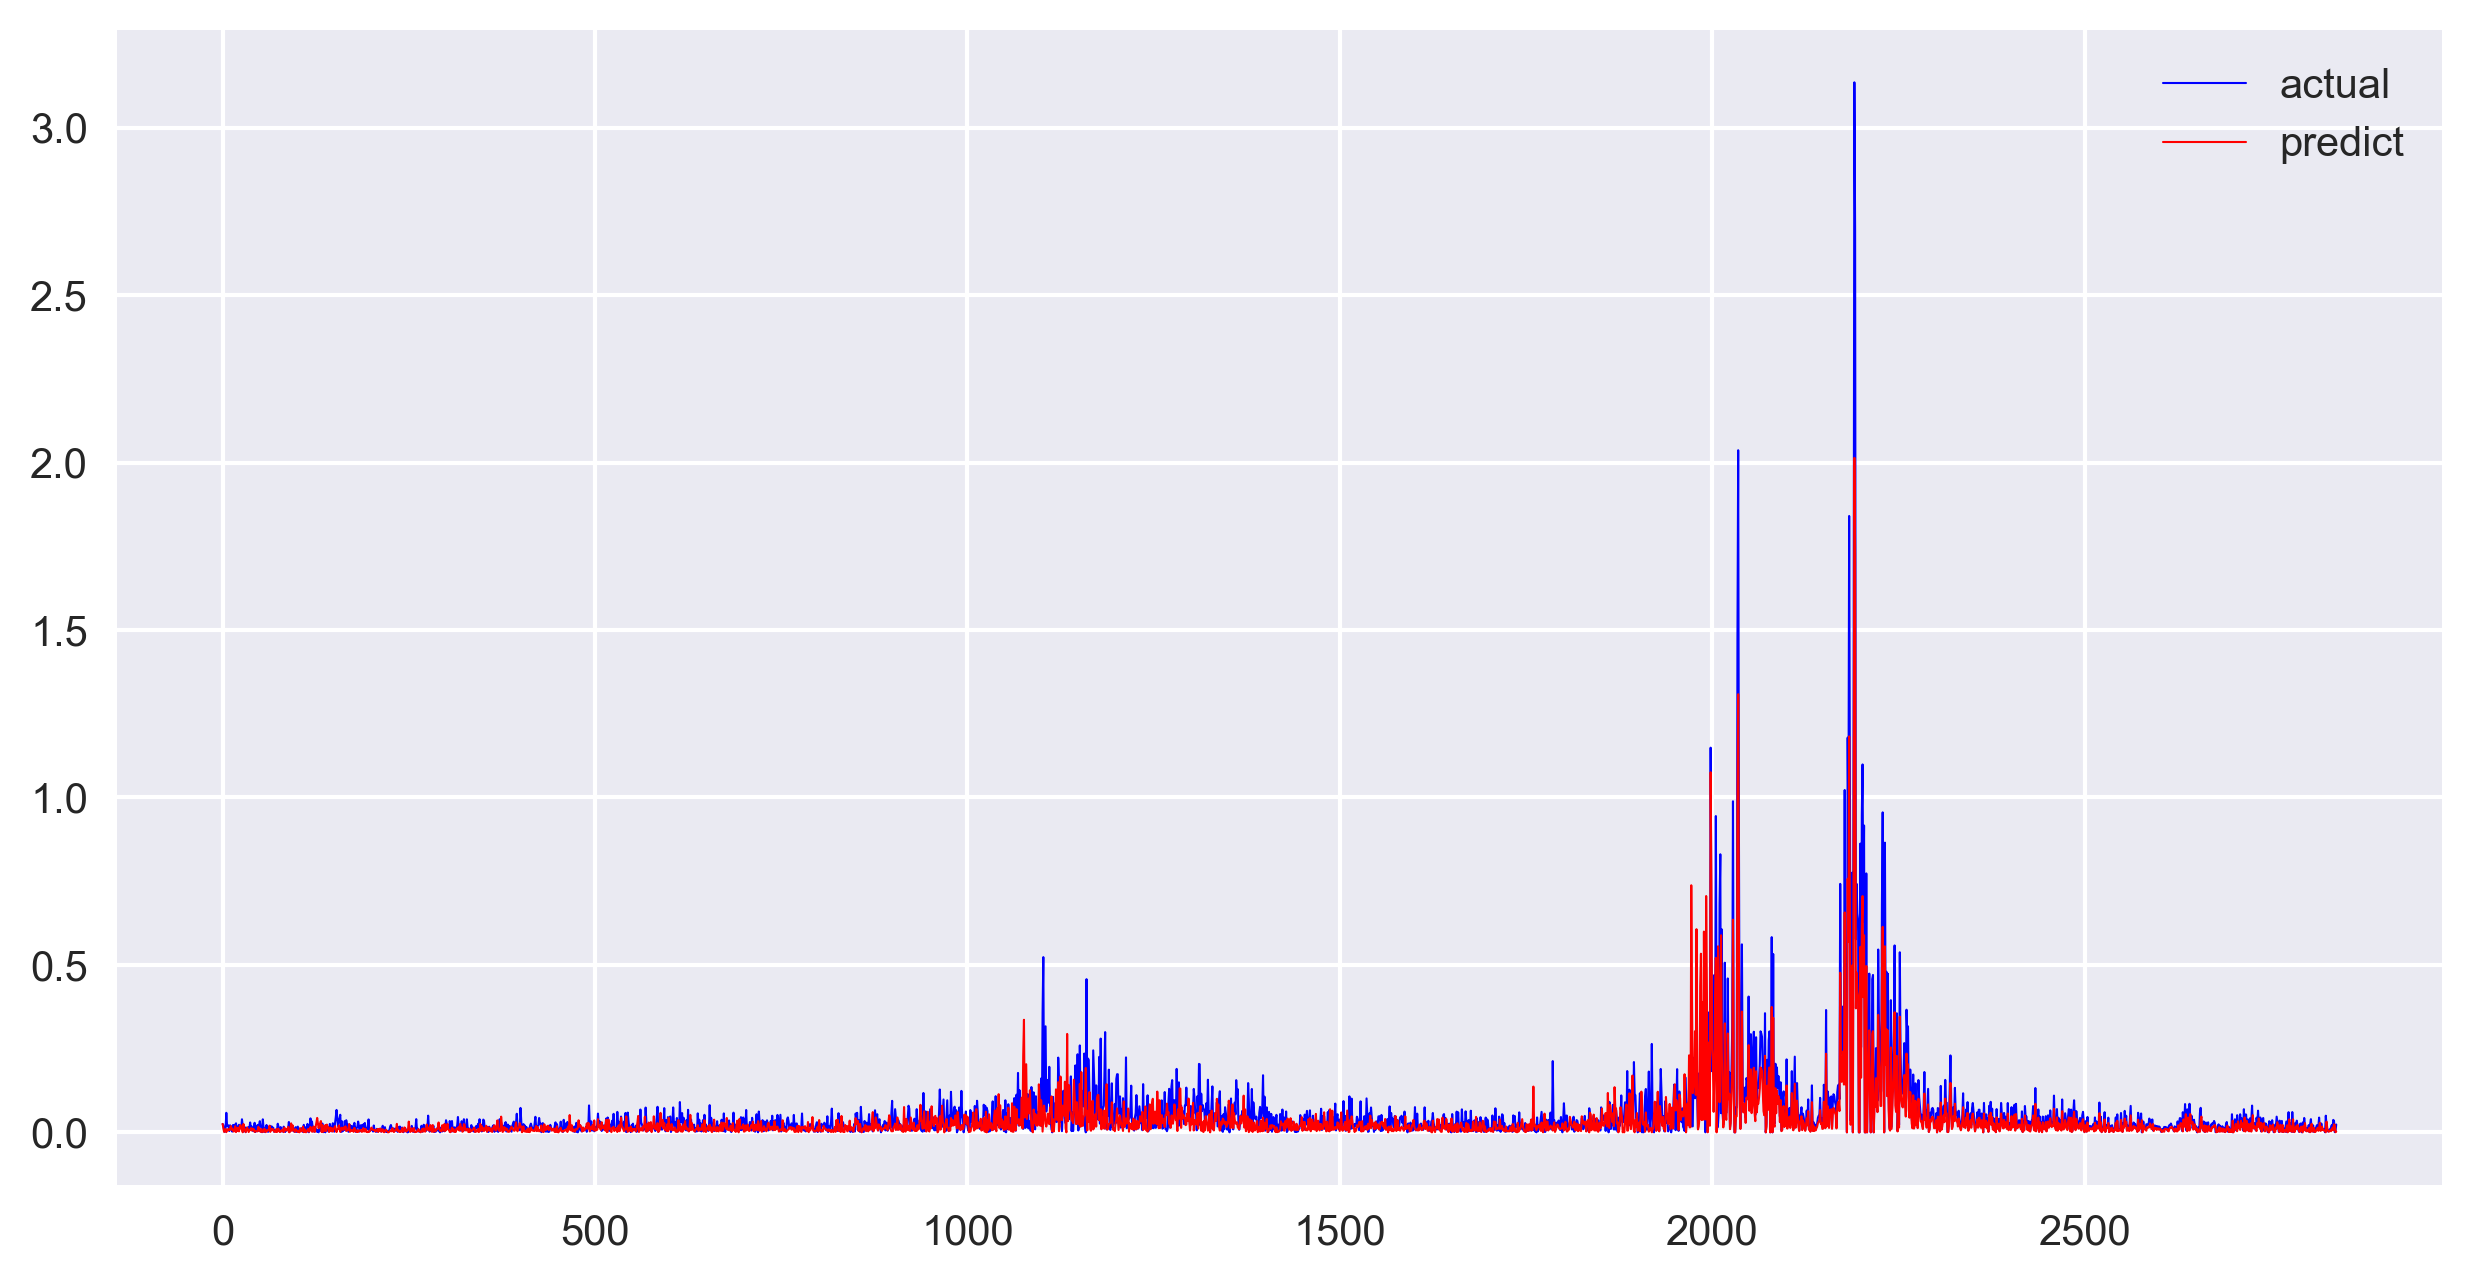

In [37]:
# Perform out of sample prediction
y_predict_har2 = results.predict(X_test)
y_predict_har2 = y_predict_har2[-(len(y_test_all)):]
y_predict_har1 = results.predict(X_train)
y_pre_all_har = np.hstack((y_predict_har1,y_predict_har2))
y_pre_all_har = y_pre_all_har[-(len(y_all_label)):]

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
axes.plot(y_all_label, 'b-',linewidth = 0.5, label='actual')
axes.plot(y_pre_all_har, 'r-', linewidth = 0.5, label='predict')

plt.legend()
#plt.grid()
plt.show()

In [38]:
print("MAE:", mean_absolute_error(y_test_all, y_predict_har2))
print("MSE:", mean_squared_error(y_test_all, y_predict_har2))
print("HMAE:", h_mean_absolute_error(y_test_all, y_predict_har2))
print("HMSE:", h_mean_squared_error(y_test_all, y_predict_har2))

MAE: 0.015462987601787033
MSE: 0.00044022006205560345
HMAE: 1.2050246644324825
HMSE: 2.6734673685472656
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
